In [1]:
from Unet import Unet
from ddpm import GaussianDiffusion, Trainer
import torch

Unet = Unet(3)
Unet.load_state_dict(
    torch.load("/home/sonwe1e/WorkStation/PracticalLearning/best_model.pt")
)
Unet.eval()
diffusion = GaussianDiffusion(Unet, 1e-4, 1e-2, 1000)
data_path = "/home/sonwe1e/WorkStation/Dataset/FFHQ/64x64/"
result = diffusion.sample(9, 1000, image_size=(3, 64, 64))

999it [00:19, 52.26it/s]


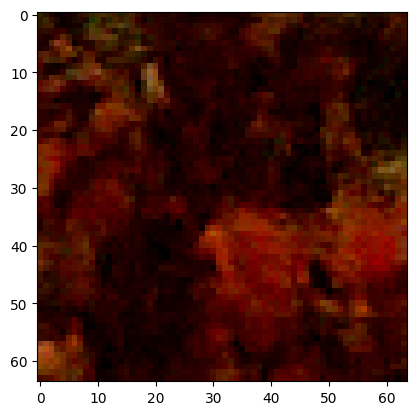

In [9]:
import matplotlib.pyplot as plt
import numpy as np

test1 = result[0][8].permute(1, 2, 0).cpu().detach().numpy()
test1 = np.clip(test1, 0, 1)
plt.imshow(test1)

In [22]:
result[0].max(), result[0].min()

(tensor(0.7138, device='cuda:0'), tensor(-0.3705, device='cuda:0'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


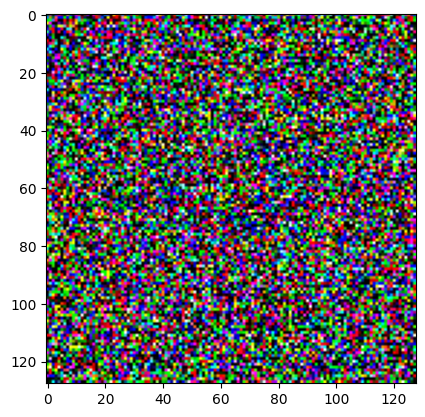

In [24]:
plt.imshow(result[1][0][0].permute(1, 2, 0).cpu().detach().numpy())